# 可以开始训练了
- by 刘道会
- 2020-08 于重庆大学

基本流程如下：
- 导入数据集
- 导入网络模型
- 定义主函数
 - 定义训练参数
 - 定义优化器
 - 定义主循环

## 0.正式开始前还是简单先测试一下

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from train.cornell_pro import Cornell
from train.ggcnn import GGCNN

In [2]:
#准备数据集
cornell_data = Cornell('cornell')
dataset = torch.utils.data.DataLoader(cornell_data,batch_size = 32)

#从数据集中读取一个样本
for x,y in dataset:
    xc = x
    yc = y
    break

In [3]:
#实例化一个网络
net = GGCNN(4)

#定义一个优化器
optimizer = optim.Adam(net.parameters())

#将输入传递到网络并计算输出
pos,cos,sin,width = net.forward(xc)

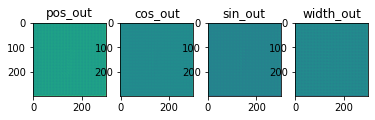

In [4]:
plt.subplot(141)
plt.title('pos_out')
plt.imshow(pos[0][0].data.numpy())
plt.subplot(142)
plt.title('cos_out')
plt.imshow(cos[0][0].data.numpy())
plt.subplot(143)
plt.title('sin_out')
plt.imshow(sin[0][0].data.numpy())
plt.subplot(144)
plt.title('width_out')
plt.imshow(width[0][0].data.numpy())
plt.show()

In [5]:
#计算损失
losses = net.compute_loss(xc,yc)
loss = losses['loss']

print(loss)

tensor(0.9131, grad_fn=<AddBackward0>)


In [6]:
#反向传播优化
optimizer.zero_grad()
loss.backward()

optimizer.step()

In [7]:
losses = net.compute_loss(xc,yc)
loss = losses['loss']

print(loss)

tensor(0.8954, grad_fn=<AddBackward0>)


可以看到经过一次优化之后，loss减小了，不过一次说明不了什么，下面就在这一个样本上优化一百次，看看loss如果变得很小的话，就说明目前的工作没有跑偏，可以继续

In [8]:
'''
device = torch.device("cuda:0")

net = net.to(device)

x = xc.to(device)
y = [yy.to(device) for yy in yc]

'''
#这些是指定GPU为训练设备的代码，但不知道为什么在jupyter notebook里面会报错，但是在spyder里面是没有问题的，训练速度那叫一个快，
#因为jupyter这边主要是为了调试，也不会真的训练，所以暂时就这样吧，不管了，用cpu就用cpu吧,不过gpu的速度比cpu快了感觉不下30倍，
#因为jupyter这开始训练之后，我spyder那边调了挺久，后面又迭代了1000次，结果回过头来jupyter这还是没迭代完100次

'\ndevice = torch.device("cuda:0")\n\nnet = net.to(device)\n\nx = xc.to(device)\ny = [yy.to(device) for yy in yc]\n\n'

In [9]:
for i in range(100):
    losses = net.compute_loss(xc,yc)
    loss = losses['loss']
    print(i)
    print(loss)
    #反向传播优化
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

tensor(0.8954, grad_fn=<AddBackward0>)
tensor(0.8776, grad_fn=<AddBackward0>)
tensor(0.8584, grad_fn=<AddBackward0>)
tensor(0.8368, grad_fn=<AddBackward0>)
tensor(0.8115, grad_fn=<AddBackward0>)
tensor(0.7806, grad_fn=<AddBackward0>)
tensor(0.7409, grad_fn=<AddBackward0>)
tensor(0.6887, grad_fn=<AddBackward0>)
tensor(0.6192, grad_fn=<AddBackward0>)
tensor(0.5291, grad_fn=<AddBackward0>)
tensor(0.4190, grad_fn=<AddBackward0>)
tensor(0.3013, grad_fn=<AddBackward0>)
tensor(0.2132, grad_fn=<AddBackward0>)
tensor(0.2207, grad_fn=<AddBackward0>)
tensor(0.2491, grad_fn=<AddBackward0>)
tensor(0.1941, grad_fn=<AddBackward0>)
tensor(0.1273, grad_fn=<AddBackward0>)
tensor(0.0951, grad_fn=<AddBackward0>)
tensor(0.0975, grad_fn=<AddBackward0>)
tensor(0.1130, grad_fn=<AddBackward0>)
tensor(0.1264, grad_fn=<AddBackward0>)
tensor(0.1321, grad_fn=<AddBackward0>)
tensor(0.1293, grad_fn=<AddBackward0>)
tensor(0.1203, grad_fn=<AddBackward0>)
tensor(0.1107, grad_fn=<AddBackward0>)
tensor(0.1068, grad_fn=<A

可以看到loss一直在降低，再可视化看一下它训练完后的预测结果，所以ojbk，开整

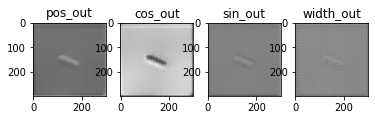

In [10]:
pos,cos,sin,width = net.forward(xc)

num = 20

plt.subplot(141)
plt.title('pos_out')
plt.imshow(pos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(142)
plt.title('cos_out')
plt.imshow(cos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(143)
plt.title('sin_out')
plt.imshow(sin[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(144)
plt.title('width_out')
plt.imshow(width[num][0].data.numpy(),cmap=plt.cm.gray)
plt.show()

可以看到，是比较符合预期的，所以，前面的工作已经做完了，后面可以集成了。

## 1.导入数据集并进行必要的参数设置

In [24]:
cornell_data = Cornell('cornell')
dataset = torch.utils.data.DataLoader(cornell_data,batch_size = 32)

batch_size = 32
batches_per_epoch = 1000
epochs = 30
lr = 0.001


## 2.导入网络模型并进行必要的参数设置

In [25]:
#实例化一个网络
net = GGCNN(4)

## 3.定义各个子函数

### 3.1定义训练函数

In [45]:
def train(epoch,net,device,train_data,optimizer,batches_per_epoch):
    """
    :功能: 执行一个训练epoch
    :参数: epoch             : 当前所在的epoch数
    :参数: net               : 要使用的网络模型
    :参数: device            : 训练使用的设备
    :参数: train_data        : 训练所用数据集
    :参数: optimizer         : 优化器
    :参数: batches_per_epoch : 每个epoch训练中所用的数据批数

    :返回: 本epoch的平均损失
    """
    #结果字典，最后返回用
    results = {
        'loss': 0,
        'losses': {
        }
    }
    
    #训练模式，所有的层和参数都会考虑进来，eval模式下比如dropout这种层会不使能
    net.train()
    
    batch_idx = 0
    
    #开始样本训练迭代
    while batch_idx < batches_per_epoch:
        for x, y in train_data:
            batch_idx += 1
            if batch_idx >= batches_per_epoch:
                break
            
            #将数据传到GPU，目前jupyter下无法使用
            # xc = x.to(device)
            # yc = [yy.to(device) for yy in y]
            
            lossdict = net.compute_loss(xc,yc)
            
            #获取当前损失
            loss = lossdict['loss']
            
            #打印一下训练过程
            if batch_idx % 2 == 0:
                print('Epoch: {}, Batch: {}, Loss: {:0.4f}'.format(epoch, batch_idx, loss.item()))
            
            #记录总共的损失
            results['loss'] += loss.item()
            #单独记录各项损失，pos,cos,sin,width
            for ln, l in lossdict['losses'].items():
                if ln not in results['losses']:
                    results['losses'][ln] = 0
                results['losses'][ln] += l.item()
            
            #反向传播优化模型
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #计算总共的平均损失
        results['loss'] /= batch_idx
        
        #计算各项的平均损失
        for l in results['losses']:
            results['losses'][l] /= batch_idx
        return results

In [46]:
def run():
    #获取设备
    device = torch.device("cuda:0")
    #net = net.to(device)
    
    #设置优化器
    optimizer = optim.Adam(net.parameters())
    
    #开始主循环
    for epoch in range(epochs):
        train_results = train(epoch, net, device, dataset, optimizer, batches_per_epoch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 300, 300])


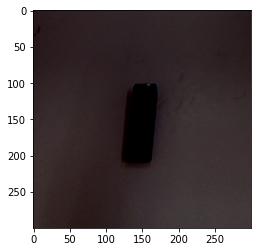

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 300, 300])


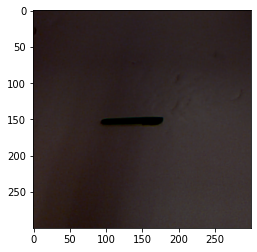

Epoch: 0, Batch: 2, Loss: 0.0820


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 300, 300])


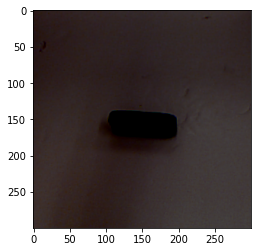

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 300, 300])


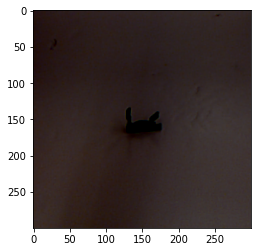

Epoch: 0, Batch: 4, Loss: 0.0684


RuntimeError: stack expects each tensor to be equal size, but got [4, 300, 300] at entry 0 and [4, 299, 300] at entry 22

In [47]:
run()

这边训练的时候，一开始没问题，后面报了这个错误，说是维度不匹配，有的图是[4,299,300]，这就说明是裁剪那块出了问题，上网查了一下也没什么结果，不过好在这是复现，ggcnn那边没报错，就说明它肯定是解决了这个问题的，cornell_data里面的get_depth和git_rgb有个resize函数，估计是解决这个问题的，我拿来试试